# The Oscars
This project functions as an extention to the major league project. In this project, i only focus on Team Lakers. The most splendid period for Lakers are 2000 to 2002 and 2009 to 2010. So i decide to choose 2000 to 2010 as the time to investigate. Classification, time series forecasting methods are applied:
        1. Classification
            1.1 Random Forest
            1.2 KNN
            1.3 Neural Network
        2. Time series forecasting  
            2.1 Prophet
            2.2 Sarima

In [1]:
# Load libraies
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load Raw Data
df = pd.read_csv("../data/nba_elo.csv",encoding ='latin' ,low_memory =False)
df.dropna()
print(df.shape)

(69636, 24)


In [3]:
df = df.drop(columns = ['neutral','playoff','elo1_post','elo2_post','carm-elo1_pre','carm-elo2_pre','carm-elo_prob1','carm-elo_prob2','carm-elo1_post','carm-elo2_post', 'raptor1_pre', 'raptor2_pre',
       'raptor_prob1', 'raptor_prob2'])

In [4]:
df['date'] = pd.to_datetime(df['date'])
print('date range: ' + str(df['date'].min()) + ' to ' + str(df['date'].max()))

date range: 1946-11-01 00:00:00 to 2020-04-15 00:00:00


In [5]:
df_LAL_1 = df.loc[df.team1 == 'LAL']
df_LAL_2 = df.loc[df.team2 == 'LAL']
df_LAL_2.rename(columns = {'team1':'team2', 'team2':'team1', 'elo1_pre':'elo2_pre', 'elo2_pre':'elo1_pre', 'elo1_prob':'elo2_prob', 'elo2_prob':'elo1_prob',
                              'score1':'score2', 'score2':'score1'}, inplace = True) 
df = pd.concat([df_LAL_1,df_LAL_2])
df.rename(columns = {'team2':'opponent'},inplace = True)

Selecting season from 2000 to 2010


In [6]:
df = df.loc[df.season > 2000]
df = df.loc[df.season < 2011]

In [7]:
df['elo_pre'] = df['elo_prob1']
def set_pre_result(row):
    if row["elo_prob1"] > row["elo_prob2"]:
        return 1
    else:
        return 0
df = df.assign(elo_pre = df.apply(set_pre_result,axis = 1))

In [8]:
df['elo_result'] = df['elo_prob1']
def set_result(row):
    if row["score1"] > row["score2"]:
        return 1
    else:
        return 0
df = df.assign(elo_result = df.apply(set_result,axis = 1))

In [9]:
from sklearn.preprocessing import LabelEncoder
object = LabelEncoder()
df['opponent'] = object.fit_transform(df['opponent'].astype('str'))

# Visulaize dataset
    To view the dataset better, i only choose 2000 to 2003 data for display. 

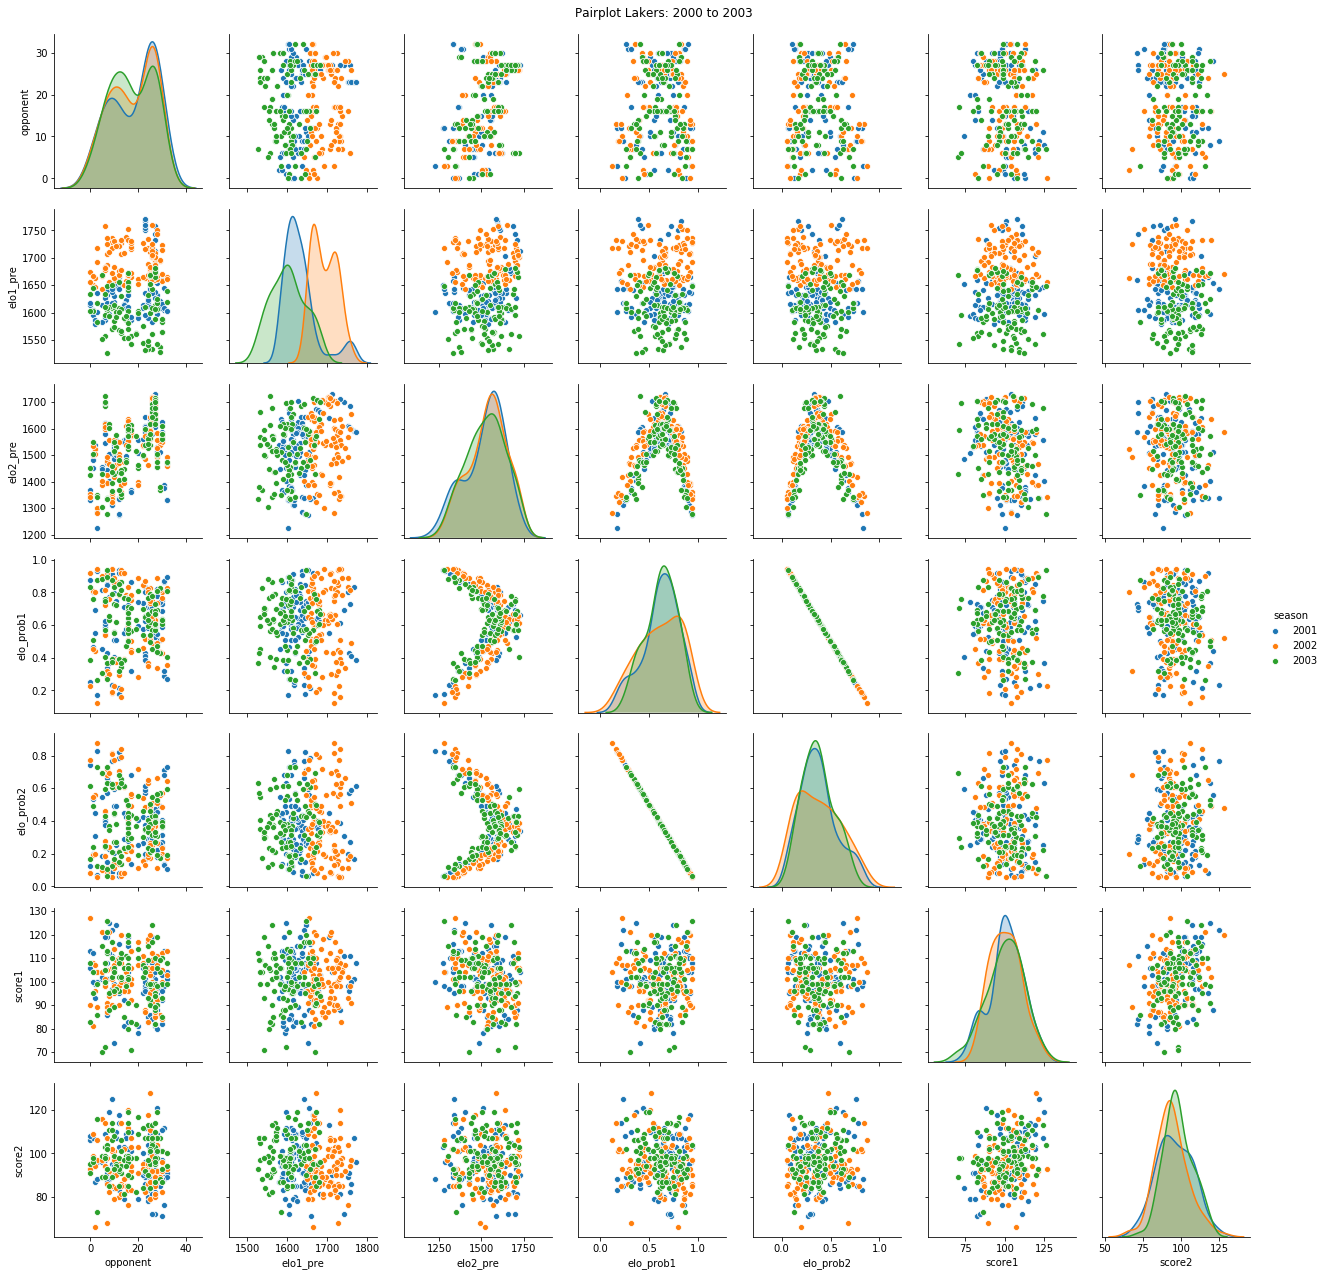

In [10]:
df_disp = df.loc[df.season < 2004]
g = sns.pairplot(df_disp, hue='season', vars=['opponent','elo1_pre','elo2_pre', 'elo_prob1','elo_prob2','score1','score2'])
g.fig.suptitle('Pairplot Lakers: 2000 to 2003', y=1.01)
plt.show()

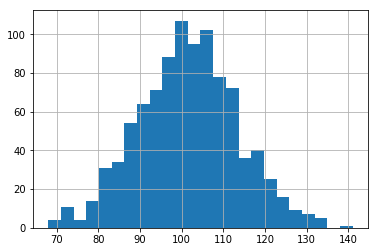

In [11]:
hist = df['score1'].hist(bins=24)

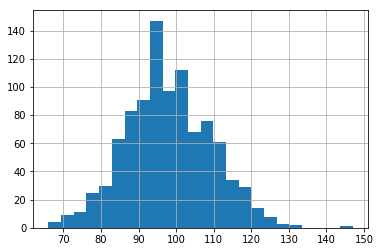

In [12]:
hist = df['score2'].hist(bins=24)

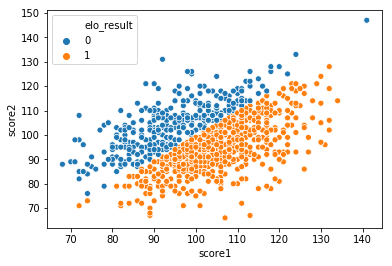

In [13]:
sns.scatterplot(x = 'score1',y = 'score2',hue = 'elo_result', data = df)

In [14]:
df['pred_ture_false'] = df['elo_prob1']
def set_pre_tf(row):
    if row["elo_pre"] == row["elo_result"]:
        return 1
    else:
        return 0
df = df.assign(pred_ture_false = df.apply(set_pre_tf,axis = 1))

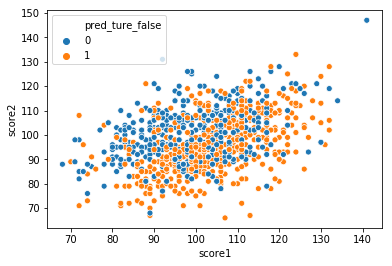

In [15]:
sns.scatterplot(x = 'score1',y = 'score2',hue = 'pred_ture_false', data = df)

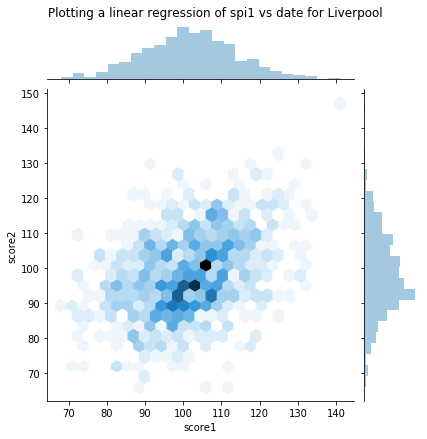

In [16]:
g = sns.jointplot(x="score1", y="score2", data=df,  kind="hex");
g.fig.suptitle('Plotting a linear regression of spi1 vs date for Liverpool', y=1.01)
plt.show()

# Calculate Feature Correlation

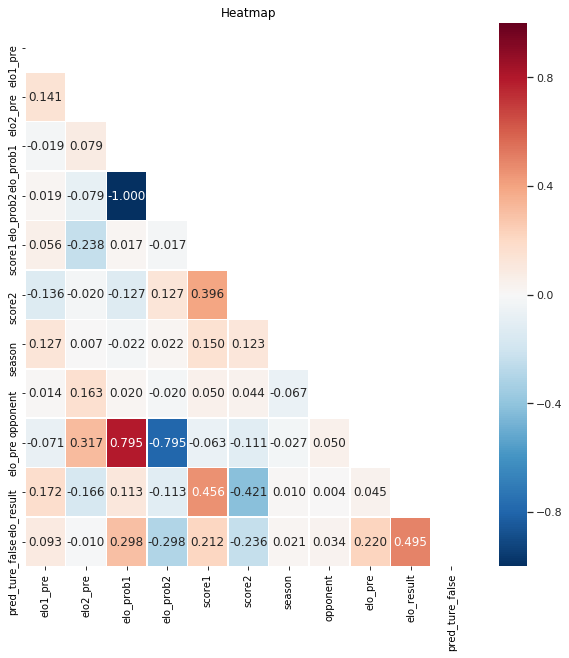

In [17]:
f, ax = plt.subplots(figsize=(10,10))
mask = np.zeros_like(df.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style='white')
sns.heatmap(df.corr(), mask = mask, cmap="RdBu_r", annot = True, linewidth = .5, fmt = ".3f",ax = ax)
ax.set_title('Heatmap')
plt.show()

# Classification
    If lakers win the game, elo_result is 1, otherwise 0. Uisng this as label, the rest, except for score 1 and score2 as features to determine if the model could predict the result correctly. 
    Classification models used are:
         1. Random Forest
         2. KNN
         3. Neural Network

In [18]:
X = df[['elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 'season','opponent']]
Y = df[['elo_result']]
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=27)
dataplot = X_test.copy()

In [19]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 40)
clf.fit(X_train, Y_train)
predict = clf.predict(X_test)
print('train score: ' + str(clf.score(X_train, Y_train)))
print('test score: ' + str(clf.score(X_test, Y_test)))

train score: 1.0
test score: 0.6649484536082474


In [20]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=40, weights='distance')
clf.fit(X_train, Y_train)
predict = clf.predict(X_test)
print('train score: ' + str(clf.score(X_train, Y_train)))
print('test score: ' + str(clf.score(X_test, Y_test)))

train score: 1.0
test score: 0.6855670103092784


In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
#clf = MLPClassifier(learning_rate='adaptive', learning_rate_init=0.01, early_stopping=True)
clf = MLPClassifier(solver='adam', alpha=1e-5,activation='relu', hidden_layer_sizes=(500,8),learning_rate='adaptive', learning_rate_init=0.001,random_state=27, early_stopping=True,max_iter=50000,verbose=False,warm_start=True)
clf.fit(X_train, Y_train)
predict = clf.predict(X_test)
predict_train = clf.predict(X_train)
test_score = accuracy_score(Y_test, predict)
train_score = accuracy_score(Y_train, predict_train)
print(train_score)
print(test_score)

0.6757105943152455
0.6649484536082474


# Time Series Forecasting
    1. Prophet
    2. Sarima

In [22]:
df_ts = df[['date','score1']]

In [23]:
df_ts.index = df_ts['date'].astype('datetime64[ns]')
df_ts_day = df_ts.resample('D').mean()

In [24]:
forecast = df_ts_day
forecast = forecast.rename(columns={ 'score1': "y" })
forecast.reset_index(level=0, inplace=True)
forecast = forecast.rename(columns={ 'date': "ds" })

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


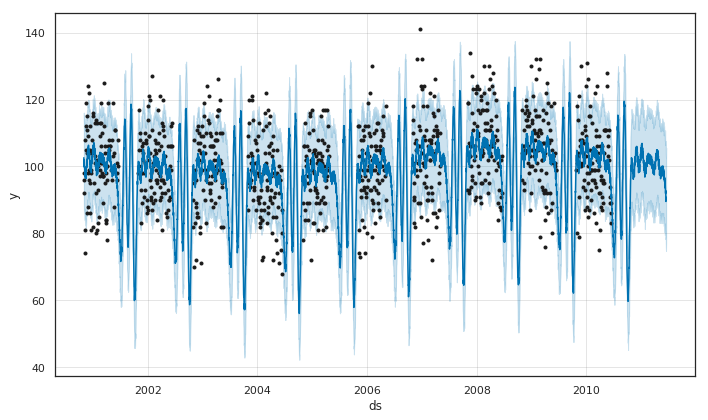

In [25]:
from fbprophet import Prophet
model = Prophet()
model.fit(forecast)
future = model.make_future_dataframe(periods=365,freq='D')
forecast = model.predict(future)
fig1 = model.plot(forecast)

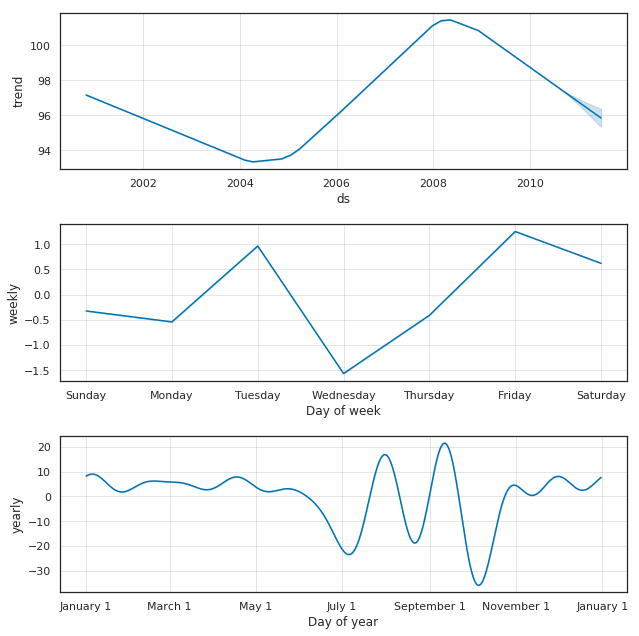

In [26]:
fig2 = model.plot_components(forecast)

In [33]:
#Fill NaN by mean
from statsmodels.tsa.arima_model import ARIMA
train = (df_ts_day - df_ts_day.mean())
train = train.fillna(train.mean())
model = ARIMA(train, order=(1, 1, 0), freq='D')
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.score1   No. Observations:                 3516
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -11984.297
Method:                       css-mle   S.D. of innovations              7.312
Date:                Fri, 20 Dec 2019   AIC                          23974.593
Time:                        19:06:50   BIC                          23993.088
Sample:                    11-01-2000   HQIC                         23981.192
                         - 06-17-2010                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0015      0.081     -0.019      0.985      -0.161       0.157
ar.L1.D.score1    -0.5202      0.014    -36.098      0.000      -0.548      -0.492
                                    

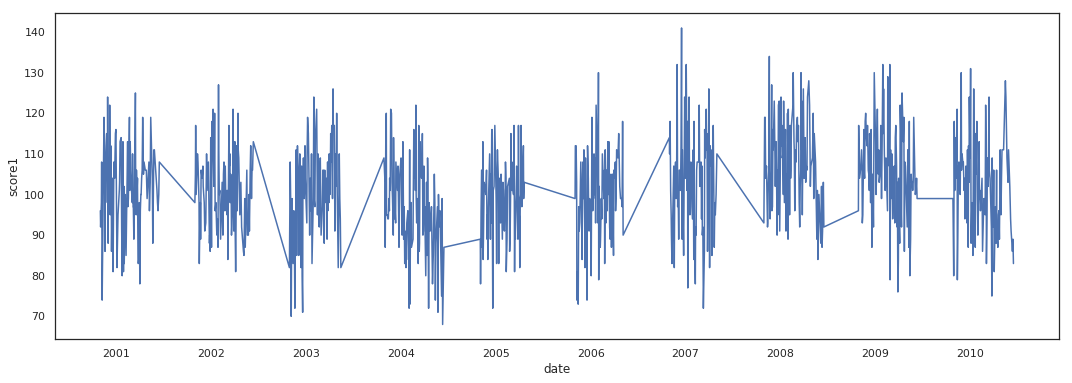

In [35]:
plt.figure(figsize = (18,6))
sns.lineplot(x = df_ts_day.index,y = 'score1',data = df_ts_day)

In [38]:
df_ts_day.fillna(df_ts_day.mean())
train_series = df_ts_day.loc[df_ts_day.index < "2009-01-01"]
test_series = df_ts_day.loc[df_ts_day.index >= "2009-01-01"]

In [42]:
#Fill NaN by mean
train_series = train_series.fillna(df_ts_day.mean())
test_series = test_series.fillna(df_ts_day.mean())

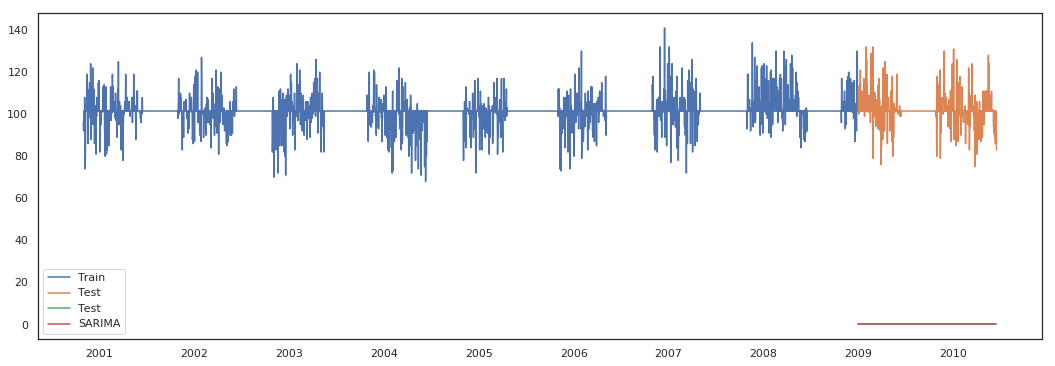

In [60]:
import statsmodels.api as sm
forecast = train_series
sarima_y_hat_avg = test_series
sarima_fit = sm.tsa.statespace.SARIMAX(forecast.score1, order=(0, 1, 2), seasonal_order=(0, 1, 1, 12)).fit()
sarima_y_hat_avg['SARIMA'] = sarima_fit.predict(start="2000-10-31", end="2011-01-01", dynamic=True)
plt.figure(figsize = (18,6))
plt.plot(forecast['score1'], label='Train')
plt.plot(test_series, label='Test')
plt.plot(sarima_y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')

# Conclusion:
    Classification accuracy:
        1. KNN : 68.50% 
        2. NN  : 66.50%
        3. RDF : 66.49%
    For this problem, time series results are also appealing. 